<a href="https://colab.research.google.com/github/ahmabboud/Spinal-Implants-Classification/blob/main/Training_Multi_Labeling_3_sobel_Cls_Balance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Label Classifier 

The Three Labels: 
**Sobel with Class Balance**
*   Plate 
*   Rode
*   Cage




In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
from fastai.vision import *
from fastai.torch_core import *
#from fastai.conv_learner import *
#from fastai.dataset import *
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import patches
import seaborn as sns
import os, cv2
from PIL import Image as PImage
from PIL import ImageDraw, ImageFont

from torchvision import transforms
import torch.utils.data
from sklearn.metrics import multilabel_confusion_matrix

import warnings
warnings.filterwarnings("ignore")

In [ ]:
!git clone https://github.com/samnaji/Quick_FastAI_Test.git
sys.path.append('/content/Quick_FastAI_Test')
from fastai_test import *

fatal: destination path 'Quick_FastAI_Test' already exists and is not an empty directory.


In [ ]:
#!pip install --upgrade gspread

# Load  Data

In [ ]:
# define path
# work path
datapath = '/content/drive/My Drive/Data_02/main_sobel'
testpath=datapath
#labels=['healthy','implant']
img_size=512
modelpath ='/content/drive/My Drive/models'

In [ ]:
from google.colab import auth
auth.authenticate_user()

import gspread
from oauth2client.client import GoogleCredentials

gc = gspread.authorize(GoogleCredentials.get_application_default())

In [ ]:
os.chdir('/content/drive/My Drive/')
os.getcwd()

'/content/drive/My Drive'

In [ ]:
worksheet = gc.open('labels_01').sheet1


# get_all_values gives a list of rows.
rows = worksheet.get_all_values()
import pandas as pd
df=pd.DataFrame.from_records(rows)
df=df.iloc[7:949,0:5]
new_header = df.iloc[0] #grab the first row for the header
df = df[1:] #take the data less the header row
df.columns = new_header #set the header row as the df header
# Drop Screw label
df.drop(['screw'], axis=1, inplace=True)
df.reset_index(drop=True, inplace=True)
df.shape

(941, 4)

In [ ]:
class_counts=[sum(df['cage']=='1'),sum(df['plate']=='1'),sum(df['rod']=='1')]
class_counts

[57, 112, 785]

In [ ]:
df.head()

7,name,rod,plate,cage
0,implant_0,,1,
1,implant_1,1,,
2,implant_2,,1,
3,implant_3,1,,
4,implant_4,1,,


In [ ]:
from  os.path import isfile
# list to hold images path
img_names = []
img_paths = []
img_labels = []
img_paths_labels = []
labels=np.array(['rod','plate','cage'])
# collect images name, labels (folder-name) into csv format

root=datapath

for i,f in enumerate(df['name']):
    
    if isfile(root+'/'+f+'.jpg'):
      f_path = f+'.jpg'
    elif isfile(root+'/'+f+'.png'):
      f_path = f+'.png'
    else:
      continue

    f_label = ",".join(labels[df.loc[i, [ 'rod', 'plate','cage']].values!=''].tolist())
    img_names.append(f)
    img_paths.append(f_path)
    img_labels.append(f_label)
    img_paths_labels.append([f_path, f_label])

# images 
print(f'total images {len(img_paths_labels)}')

# convert to df to save it as csv
dfn = pd.DataFrame(img_paths_labels,columns=['img_names','tags'])
dfn.sample(3)

total images 939


,img_names,tags
460,implant_461.jpg,rod
842,implant_844.jpg,rod
268,implant_269.png,rod


rod               721
plate              82
                   59
rod,cage           39
rod,plate          20
cage                9
plate,cage          5
rod,plate,cage      4
Name: tags, dtype: int64


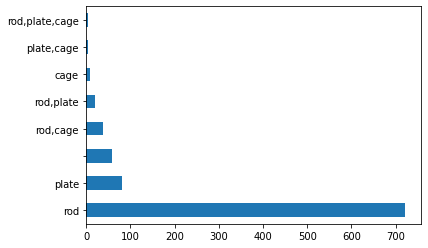

In [ ]:

# print labels
print(dfn['tags'].value_counts())
# label counts
dfn['tags'].value_counts().plot(kind='barh')

In [ ]:
dfn['tags'].replace('', np.nan, inplace=True)
dfn.dropna(subset=['tags'],inplace=True)
print(dfn['tags'].value_counts())

rod               721
plate              82
rod,cage           39
rod,plate          20
cage                9
plate,cage          5
rod,plate,cage      4
Name: tags, dtype: int64


## Split Train and Test Set

In [ ]:
# Split DF into Train and Test 
np.random.seed(42)
msk = np.random.rand(len(dfn)) < 0.7  #70% Train
train_df = dfn[msk]
test_df = dfn[~msk]
len(train_df),len(test_df)

(621, 259)

In [ ]:
# file to save Test image path/name and labels
test_df_file = os.path.join(datapath,'test_MultiLabel_Data02.csv')
# save to csv 
test_df.to_csv(test_df_file, index=False)

In [ ]:
# file to save train image path/name and labels
train_df_file = os.path.join(datapath,'train_MultiLabel_Data02.csv')
# save to csv 
train_df.to_csv(train_df_file, index=False)

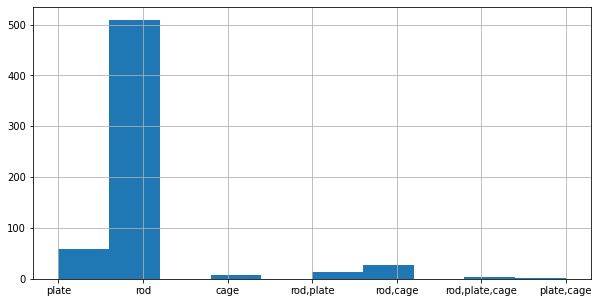

In [ ]:
train_df['tags'].hist(figsize = (10, 5))

In [ ]:
# define transform
#tfms = get_transforms() # default
#tfms = None # no transform
tfms = get_transforms(do_flip=True  # random flip with prob 0.5
                      , flip_vert=False # flip verticle or rotated by 90
                      , max_rotate=3 # rotation with prob p_affine
                      , max_zoom=1.2  # zoom between 1 and value
                      , max_lighting=0  # lighting and contrast
                      , max_warp=0 # symmetric wrap with prob p_affine
                      , p_affine=0.5  # prob 
                      , p_lighting=0 # prob of lighting
                     )

# read dataset

dataset = ImageDataBunch.from_csv(path=datapath  # path having csv_labels file created above
                               #,folder='./veggie' #datapath # data folder relative to path
                               ,csv_labels=train_df_file#'Preproc_comb_train.csv'  # images labeled file name
                               ,ds_tfms=tfms  # transform
                               ,fn_col=0  # indx/name of col having file names 
                               ,label_col=1  # indx/name of col having labels 
                               ,label_delim=','
                               ,header=1
                               ,size=img_size
                               ,bs=4          # for testing purpose set to low number
                              ).normalize(imagenet_stats) # normalize images

# show labels
print(dataset.classes)
# number of classes
print(len(dataset.classes),dataset.c)


['cage', 'plate', 'rod']
3 3


In [ ]:
#dataset.show_batch()

In [ ]:
# check to make sure you set the device
#torch.cuda.set_device(0)

## Using BCE Losses

In [ ]:


class BCE_Loss(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
    def get_weight(self,x,t):
        return None
    def forward(self, pred, targ):
        t=targ                                            # AHB
        x=pred
        w = self.get_weight(x,t)
        return F.binary_cross_entropy_with_logits(x, t, w, size_average=False)/self.num_classes
    


loss_f = BCE_Loss(3)

In [ ]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
model = models.resnet50
learn = cnn_learner(dataset, model, metrics=[acc_02,f_score,] ,loss_func=loss_f )
#learn.crit=loss_f 
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,2.659572,2.581581,0.666667,0.671217,00:29
1,1.630593,0.917461,0.892473,0.897785,00:29


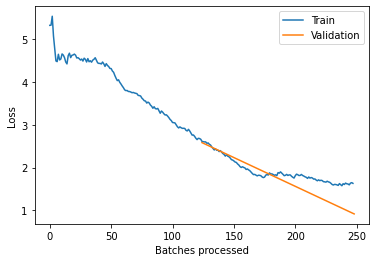

In [ ]:
learn.recorder.plot_losses()

## Using Focal Loss

In [ ]:


#src:https://forums.fast.ai/t/deeplearning-lec9-notes/14113
class FocalLoss(BCE_Loss):
    def get_weight(self,x,t):
        alpha,gamma = 0.25,2.
        p = x.sigmoid()
        pt = p*t + (1-p)*(1-t)
        w = alpha*t + (1-alpha)*(1-t)
        return w * (1-pt).pow(gamma)
    def forward(self, pred, targ):
        #t = one_hot_embedding(targ, self.num_classes+1)
        t=targ 
        x=pred
        w = self.get_weight(x,t)
        return F.binary_cross_entropy_with_logits(x, t, w.detach(), size_average=False)/self.num_classes
    
loss_f = FocalLoss(3)

In [ ]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
model = models.resnet50
learn = cnn_learner(dataset, model ,metrics=[acc_02,f_score,],loss_func=loss_f )
#learn.crit=loss_f 
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,1.186086,0.715809,0.551075,0.726900,01:11
1,0.546100,0.232570,0.717742,0.784754,00:26
2,0.360458,0.249008,0.768817,0.839833,00:26
3,0.287372,0.173820,0.827957,0.871451,00:27
4,0.283012,0.149474,0.876344,0.902877,00:27


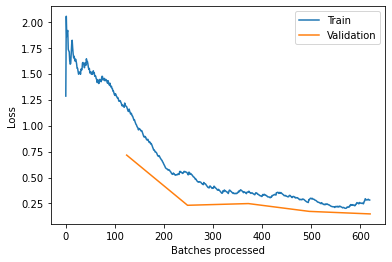

In [ ]:
learn.recorder.plot_losses()

## Weighted MultiLabel Soft Margin Loss 

In [ ]:
Rescaled_weights=Tensor([min(class_counts)/class_count for class_count in class_counts]).to(device="cuda")
Rescaled_weights

tensor([1.0000, 0.5089, 0.0726], device='cuda:0')

In [ ]:

class MultiLblSoftMarginLoss(nn.BCELoss):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
    def get_weight(self,x,t):
      
        return None
    def forward(self, pred, targ):
        #t = one_hot_embedding(targ, self.num_classes+1)
        t=targ 
        x=pred
        w = Rescaled_weights
        #return F.binary_cross_entropy_with_logits(x, t, w.detach(), size_average=False)/self.num_classes
        return F.multilabel_soft_margin_loss(input=x, target=t, weight=w, size_average=True)/self.num_classes
    
loss_f = MultiLblSoftMarginLoss(3)

In [ ]:
F.multilabel_soft_margin_loss()

In [ ]:
??nn.BCELoss

In [ ]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
#f1_score = FBeta(average='weighted', beta=1)
model = models.resnet50
learn = cnn_learner(dataset, model, metrics=[acc_02,f_score],loss_func=loss_f)#
#learn.crit=F.MultiLabelSoftMarginLoss()

In [ ]:
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.110629,0.101626,0.599462,0.647058,00:46
1,0.064293,0.041828,0.897850,0.905949,00:46


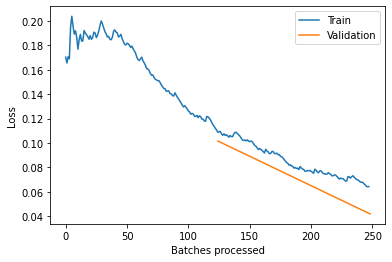

In [ ]:
learn.recorder.plot_losses()

# Training (freeze) on Preproccessed

### Stage 0

In [ ]:
# learning rate finder
#learn.lr_find()
# plot the lr_find to get better learning rate
# learning rate vs loss
#learn.recorder.plot()
#learn.recorder.plot(suggestion=True)
learn.fit_one_cycle(5) 

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,1.036376,1.204282,0.395161,0.673562,01:29
1,0.852375,0.516763,0.583333,0.737007,00:25
2,0.647384,0.302709,0.798387,0.867832,00:24
3,0.491444,0.243024,0.827957,0.887225,00:24
4,0.398275,0.238486,0.844086,0.902237,00:23


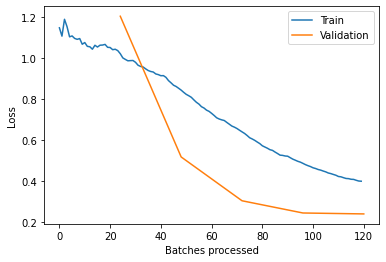

In [ ]:
learn.recorder.plot_losses()

In [ ]:
model_path= os.path.join(modelpath,'Data_02_512_epoch_5_freeze_Blc_CLS')

In [ ]:

model_dr=learn.save(model_path, return_path=True)

In [ ]:
learn.load(model_path)

# Training On Preprocessed 


In [ ]:
learn.unfreeze()
# learning rate finder
#learn.lr_find()
# plot the lr_find to get better learning rate
# learning rate vs loss
#learn.recorder.plot()
#learn.recorder.plot(suggestion=True)

### Stage 1

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(10, max_lr=slice(1e-6,1e-4)) 


epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,4.551187,3.738938,0.922043,0.873656,00:28
1,4.723576,5.289190,0.905914,0.833333,00:28
2,4.856319,3.196288,0.924731,0.889785,00:28
3,4.412383,5.836671,0.916667,0.865591,00:28
4,4.333939,2.849591,0.916667,0.865591,00:28
5,4.055562,5.436885,0.919355,0.881720,00:28
6,4.421537,3.122609,0.919355,0.873656,00:28
7,3.849195,4.305892,0.922043,0.881720,00:28
8,4.715877,2.877267,0.922043,0.881720,00:28
9,4.017263,5.104285,0.919355,0.873656,00:28


FileNotFoundError: ignored

In [ ]:
learn.fit_one_cycle(5, max_lr=1e-6) 

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,4.589980,3.349680,0.913978,0.857527,00:27
1,3.988502,3.293653,0.922043,0.881720,00:28
2,4.109751,7.974687,0.916667,0.865591,00:27
3,4.644506,6.706676,0.916667,0.865591,00:27
4,4.341198,8.091807,0.919355,0.873656,00:28


In [ ]:
modelpath='/content/drive/My Drive/Data_02/models'
model_path= os.path.join(modelpath,'Data_02_512_epoch_15_Blc_CLS')
model_dr=learn.save(model_path, return_path=True)

In [ ]:
learn.fit_one_cycle(3, max_lr=1e-5) 

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,4.247967,3.115426,0.916667,0.865591,00:27
1,4.619966,3.738348,0.916667,0.873656,00:27
2,3.718221,2.759248,0.924731,0.889785,00:26


In [ ]:
modelpath='/content/drive/My Drive/Data_02/models'
model_path= os.path.join(modelpath,'Data_02_512_epoch_20_Blc_CLS')
model_dr=learn.save(model_path, return_path=True)

In [ ]:
learn.recorder.plot_losses()

In [ ]:
#model_path= os.path.join(modelpath,'Data_02_512_epoch_15_Blc_CLS')
#learn.load(model_path)

# Interp

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.plot_multi_top_losses(10,figsize=(5,5))

In [ ]:
#interp.plot_confusion_matrix(figsize=(7,7), dpi=60)

In [ ]:
#interp.plot_top_losses(10)

In [ ]:
#len(dataset.valid_ds),len(losses),len(idxs)

In [ ]:
#interp.plot_top_losses(9, figsize=(15,11), heatmap=True)


## Export Model

In [ ]:
# export the model
learn.export('/content/drive/My Drive/models/Export_Mul_Lab_Res50_Blc_CLS.pkl')
print("Model Saved!")

Model Saved!


## Test Model

In [ ]:
test_set=ImageList.from_df(test_df, path=datapath)
dataset.add_test(test_set)
#dataset

In [ ]:
learn.model.eval()

In [ ]:
# get_preds() calculate the accuracy consecutively 
preds,*_ =learn.get_preds(DatasetType.Test)
preds = preds.detach().numpy()

In [ ]:
pred_msk = np.asarray(preds>0.5, dtype=np.int32)

In [ ]:
#Actual
test_set_lbl=test_set.split_none().label_from_df('tags',label_delim=',')
print(test_set_lbl.train.y.c2i)
y=[test_set_lbl.train.y[i].data for i in range(len(test_set_lbl.train.y))]

{'cage': 0, 'plate': 1, 'rod': 2}


In [ ]:
# get_preds() calculate the accuracy consecutively 
#preds2=[np.asarray(learn.predict(test_set_lbl.train.x[i])[0].data for i in range(len(test_set_lbl.train.x))]
#pred_msk=preds2.copy()

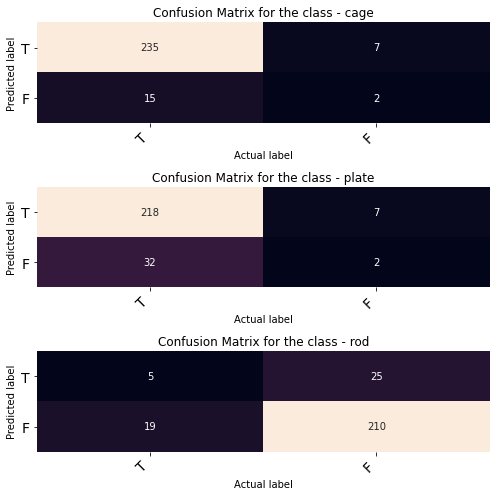

In [ ]:
 cm = multilabel_confusion_matrix(y, pred_msk)
 labels =['cage', 'plate', 'rod']

 import seaborn as sns


def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_xlabel('Actual label')
    axes.set_ylabel('Predicted label')
    axes.set_title("Confusion Matrix for the class - " + class_label)

fig, ax = plt.subplots(3, 1, figsize=(7, 7))
    
for axes, cfs_matrix, label in zip(ax.flatten(), cm, labels):
        print_confusion_matrix(cfs_matrix, axes, label, ["T", "F"])
    
fig.tight_layout()
plt.show()  

In [ ]:
from sklearn.metrics import accuracy_score
Accuracy=accuracy_score(y,pred_msk)
Accuracy

0.7413127413127413

# Train on imbalanced dataset with Focal Loss

In [ ]:
# ref:https://www.kaggle.com/tanlikesmath/oversampling-mnist-with-fastai
# Default Fast AI Random Sampler 
dataset.train_dl.dl.sampler

(array([[2., 0., 0., 0., ..., 0., 0., 0., 1.],
        [2., 0., 0., 0., ..., 0., 0., 0., 1.],
        [2., 0., 0., 0., ..., 0., 0., 0., 1.],
        [2., 0., 0., 0., ..., 0., 0., 0., 1.],
        ...,
        [1., 0., 0., 0., ..., 0., 0., 0., 2.],
        [2., 0., 0., 0., ..., 0., 0., 0., 1.],
        [2., 0., 0., 0., ..., 0., 0., 0., 1.],
        [2., 0., 0., 0., ..., 0., 0., 0., 1.]]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ], dtype=float32),
 <a list of 460 Lists of Patches objects>)

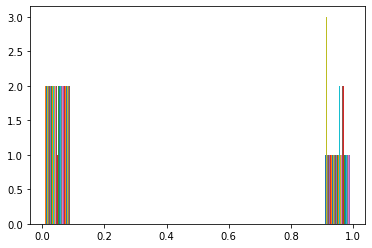

In [ ]:
labels = []
for img,target in dataset.train_dl.dl:
    labels.append(target)
labels = torch.cat(labels)
plt.hist(labels)

If we instead use a weighted random sampler with weights that are inverse of the counts of the labels, we can get a relatively balanced distribution

In [ ]:
np.bincount([dataset.train_dl.dataset.y[i].data for i in range(len(dataset.train_dl.dataset))])

In [ ]:
dataset.train_dl.dataset.y[1].data

array([0., 0., 1.], dtype=float32)

In [ ]:
np.unique(dataset.train_ds.y.items,return_counts=True)

(array([list([0]), list([1]), list([2]), list([2, 0]), list([2, 1]), list([2, 1, 0])], dtype=object),
 array([  6,  49, 401,  25,  11,   4]))

In [ ]:
def detn_loss(input, target,print_it=True):
    print(target)
    bb_t,c_t = target
    bb_i,c_i = input[:, :4], input[:, 4:]
    bb_i = F.sigmoid(bb_i)*224
    # I looked at these quantities separately first then picked a multiplier
    #   to make them approximately equal
    return F.l1_loss(bb_i, bb_t) + F.cross_entropy(c_i, c_t)*20

def detn_l1(input, target):
    bb_t,_ = target
    bb_i = input[:, :4]
    bb_i = F.sigmoid(bb_i)*224
    return F.l1_loss(V(bb_i),V(bb_t)).data

def detn_acc(input, target):
    _,c_t = target
    c_i = input[:, 4:]
    return accuracy(c_i, c_t)

In [ ]:


# total SSD loss for batch
def ssd_loss(pred,targ,print_it=True):
    lcs,lls = 0.,0.
    for b_c,b_bb,bbox,clas in zip(*pred,*targ):
        loc_loss,clas_loss = ssd_1_loss(b_c,b_bb,bbox,clas,print_it)
        lls += loc_loss
        lcs += clas_loss
    if print_it: print(f'loc: {lls.data[0]}, clas: {lcs.data[0]}')
    return lls+lcs


# SSD loss for one image
def ssd_1_loss(b_c,b_bb,bbox,clas,print_it=False):
    
    # get bounding box and classes
    bbox,clas = get_y(bbox,clas)
    
    # activations to bounding box
    a_ic = actn_to_bb(b_bb, anchors)
    
    # calculate overlaps
    overlaps = jaccard(bbox.data, anchor_cnr.data)
    
    # get the overlaps based on the criteria
    gt_overlap,gt_idx = map_to_ground_truth(overlaps,print_it)
    
    # get the classes
    gt_clas = clas[gt_idx]
    
    # find the positives
    pos = gt_overlap > 0.4
    pos_idx = torch.nonzero(pos)[:,0]
    
    # do the cell assignments
    gt_clas[1-pos] = len(id2cat)
    gt_bbox = bbox[gt_idx]
    
    # calc L1 loss and cross entropy loss
    loc_loss = ((a_ic[pos_idx] - gt_bbox[pos_idx]).abs()).mean()
    clas_loss  = loss_f(b_c, gt_clas)
    return loc_loss, clas_loss

In [ ]:
defaults.device = torch.device('cuda')

In [ ]:
dataset.batch_size=3

In [ ]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
model = models.resnet50
learn = cnn_learner(dataset, model, metrics=[acc_02,f_score])#,detn_acc, detn_l1

RuntimeError: ignored

In [ ]:
learn.loss_func.func = nn.BCELoss
#learn.loss_func=detn_loss
learn.fit_one_cycle(2)

In [ ]:
learn.crit = ssd_loss
#learn.metrics = [detn_acc, detn_l1]

In [ ]:
class Llossflat(nn.BCELoss):
  def forward(self,input:Tensor,target:Tensor)->Rank0Tensor:
    return super().forward(input.view(-1),target.view(-1))


In [ ]:
#src:https://forums.fast.ai/t/deeplearning-lec9-notes/14113
class FocalLoss(nn.BCELoss):
    def get_weight(self,x,t):
        alpha,gamma = 0.25,2.
        p = x.sigmoid()
        pt = p*t + (1-p)*(1-t)
        w = alpha*t + (1-alpha)*(1-t)
        return w * (1-pt).pow(gamma)

loss_f = FocalLoss()

In [ ]:
learn.loss_func=loss_f
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


tensor([[0., 0., 1.],
        [0., 0., 1.]], device='cuda:0')


ValueError: ignored